# Supervised Learning

This notebook is for supervised learning of the dataset, for comparison with
the UCL model in the Unsupervised notebook.

The expected input is a text file generated by the Preprocessing notebook.

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import utilities
import seaborn as sns

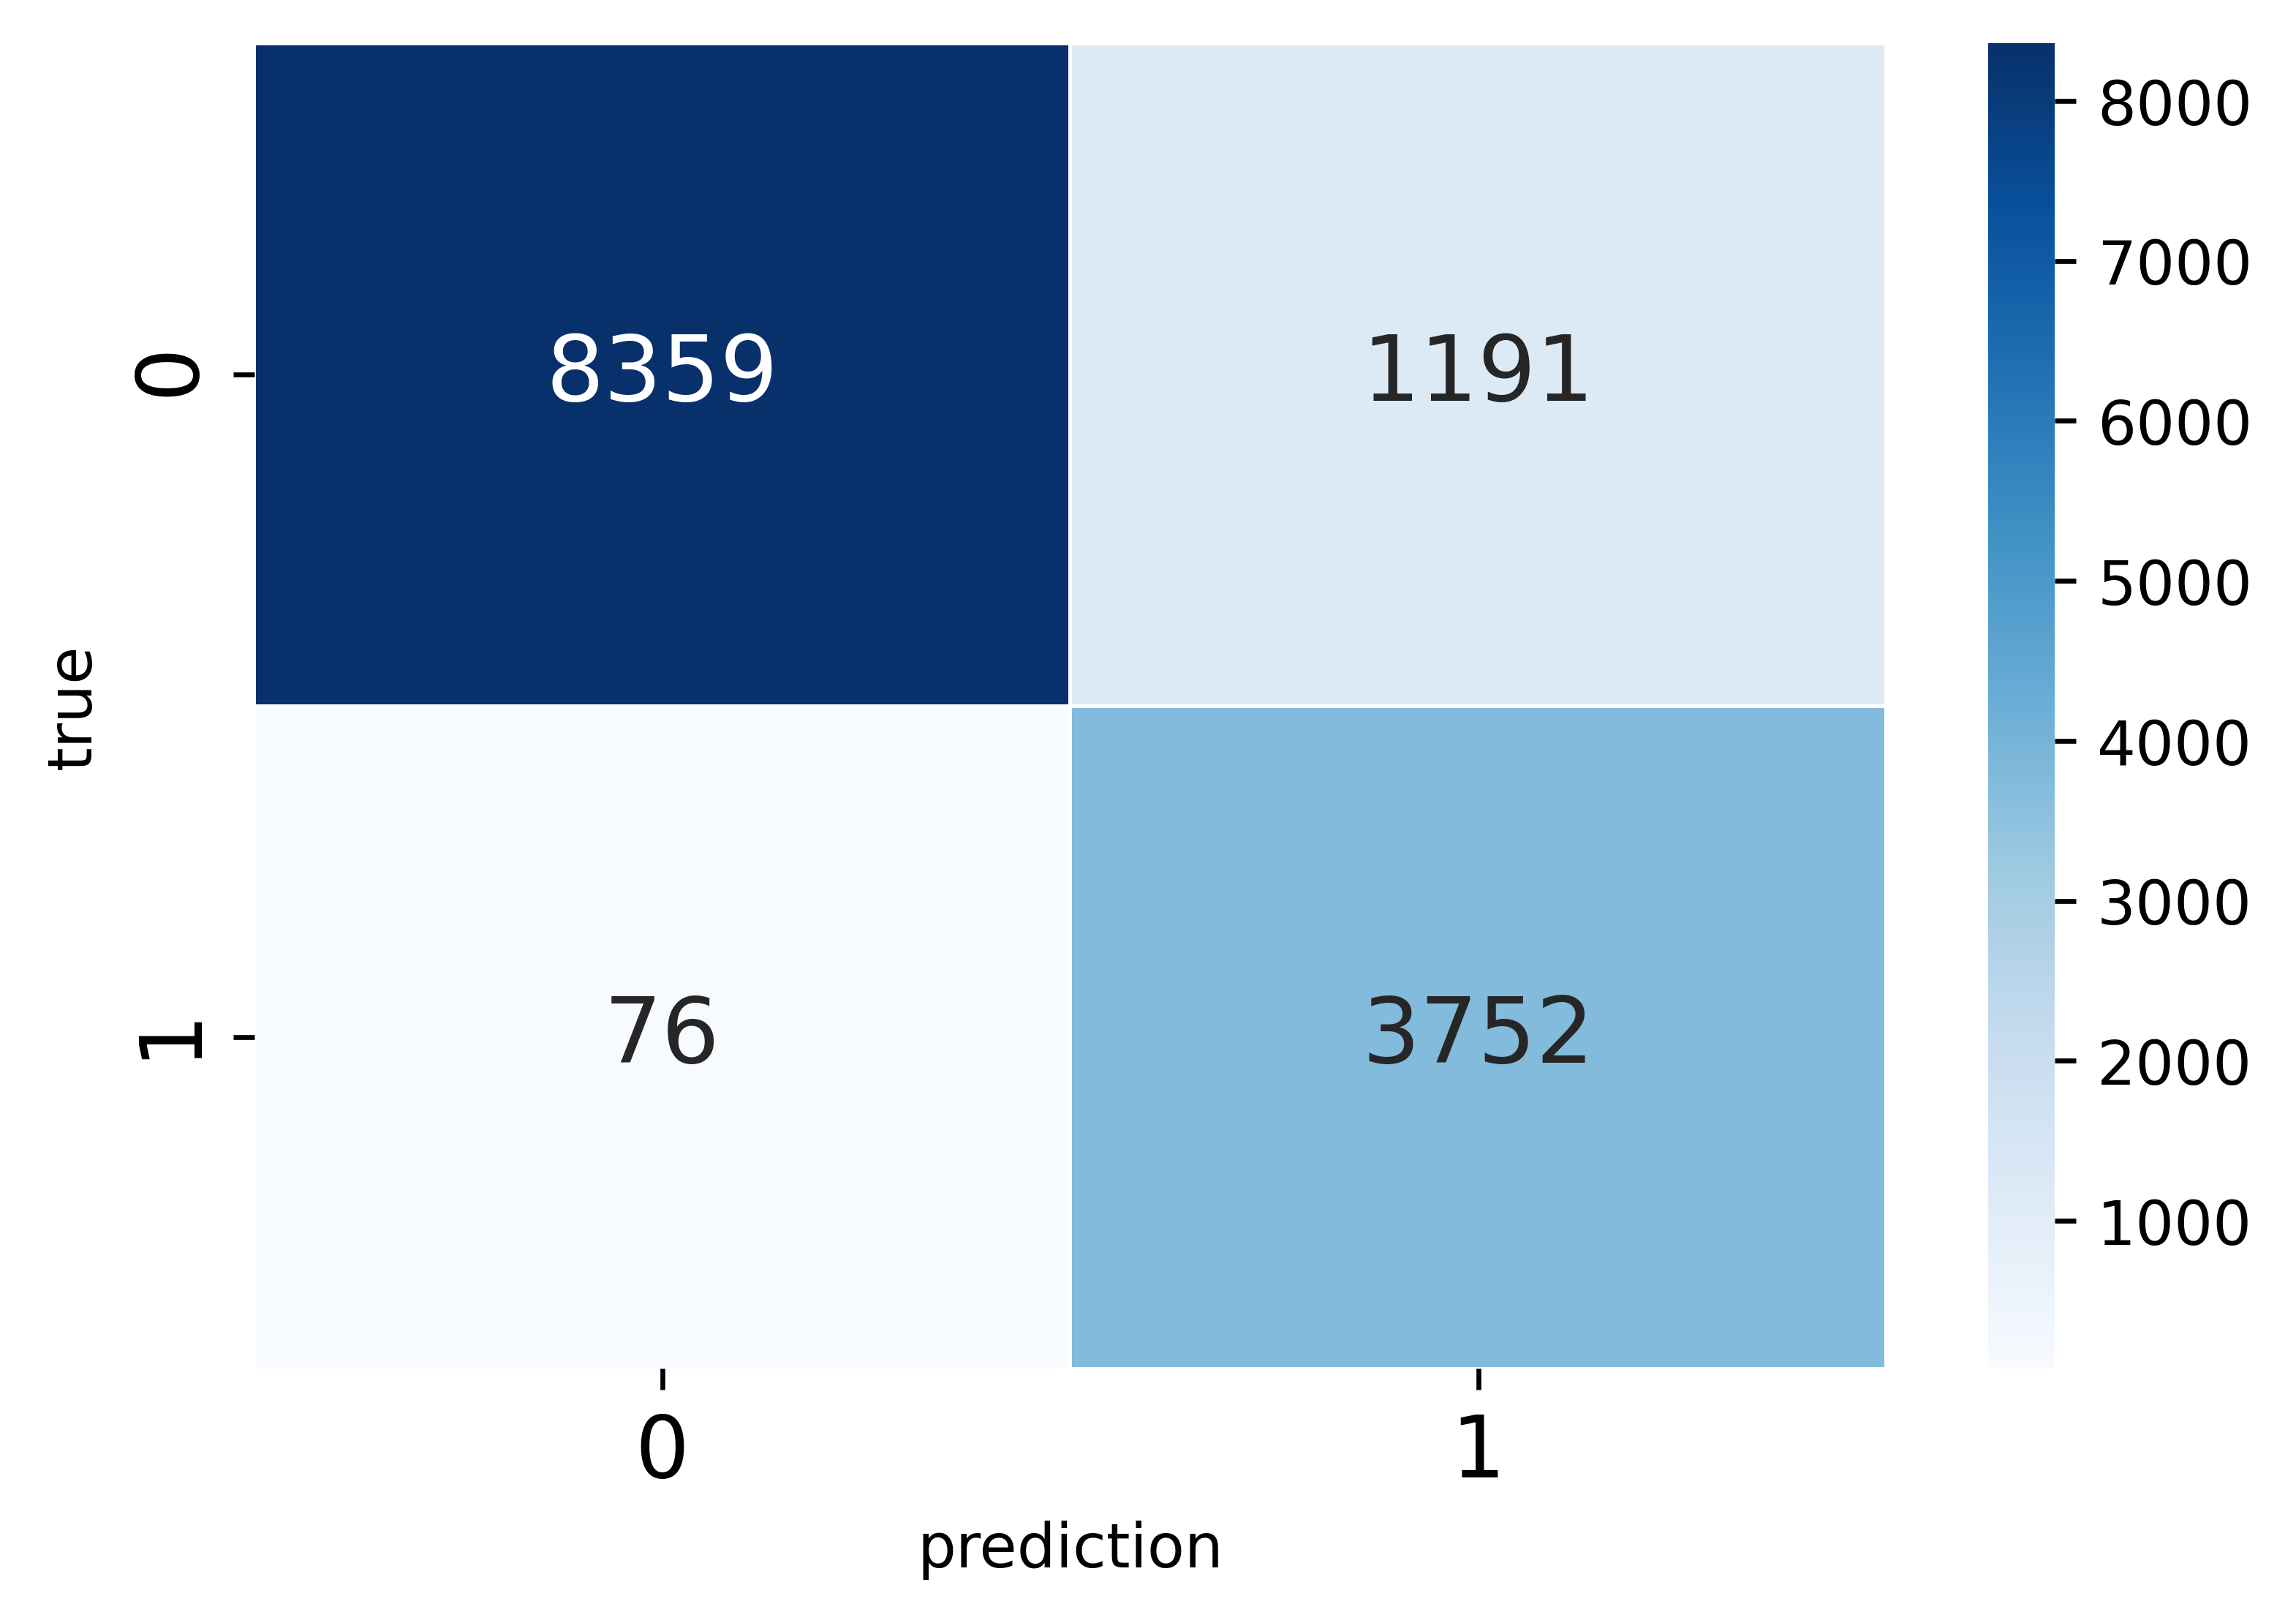

In [66]:
preds = pd.read_csv("supervised_misclassified.csv")
preds = preds.rename(columns={"pred":"prediction"})
cm = pd.crosstab(preds["true"], preds["prediction"])
plt.figure(dpi = 600) 
cm[0] = [8359, 76]
cm[1] = [1191, 3752]
sns.heatmap(cm, annot=True, annot_kws={"size": 15}, fmt='d', cmap = 'Blues', linewidth=.5)
plt.tick_params(labelsize = 14) # x font label size
plt.tick_params(labelsize = 14) # y font label size

In [67]:
cm = cm.rename(columns={0:"background"})
cm = cm.rename(columns={1:"grass"})
cm=cm.rename(index = {0:"background"})
cm=cm.rename(index = {1:"grass"})

In [68]:
cm

prediction  background  grass
true                         
background        8359   1191
grass               76   3752

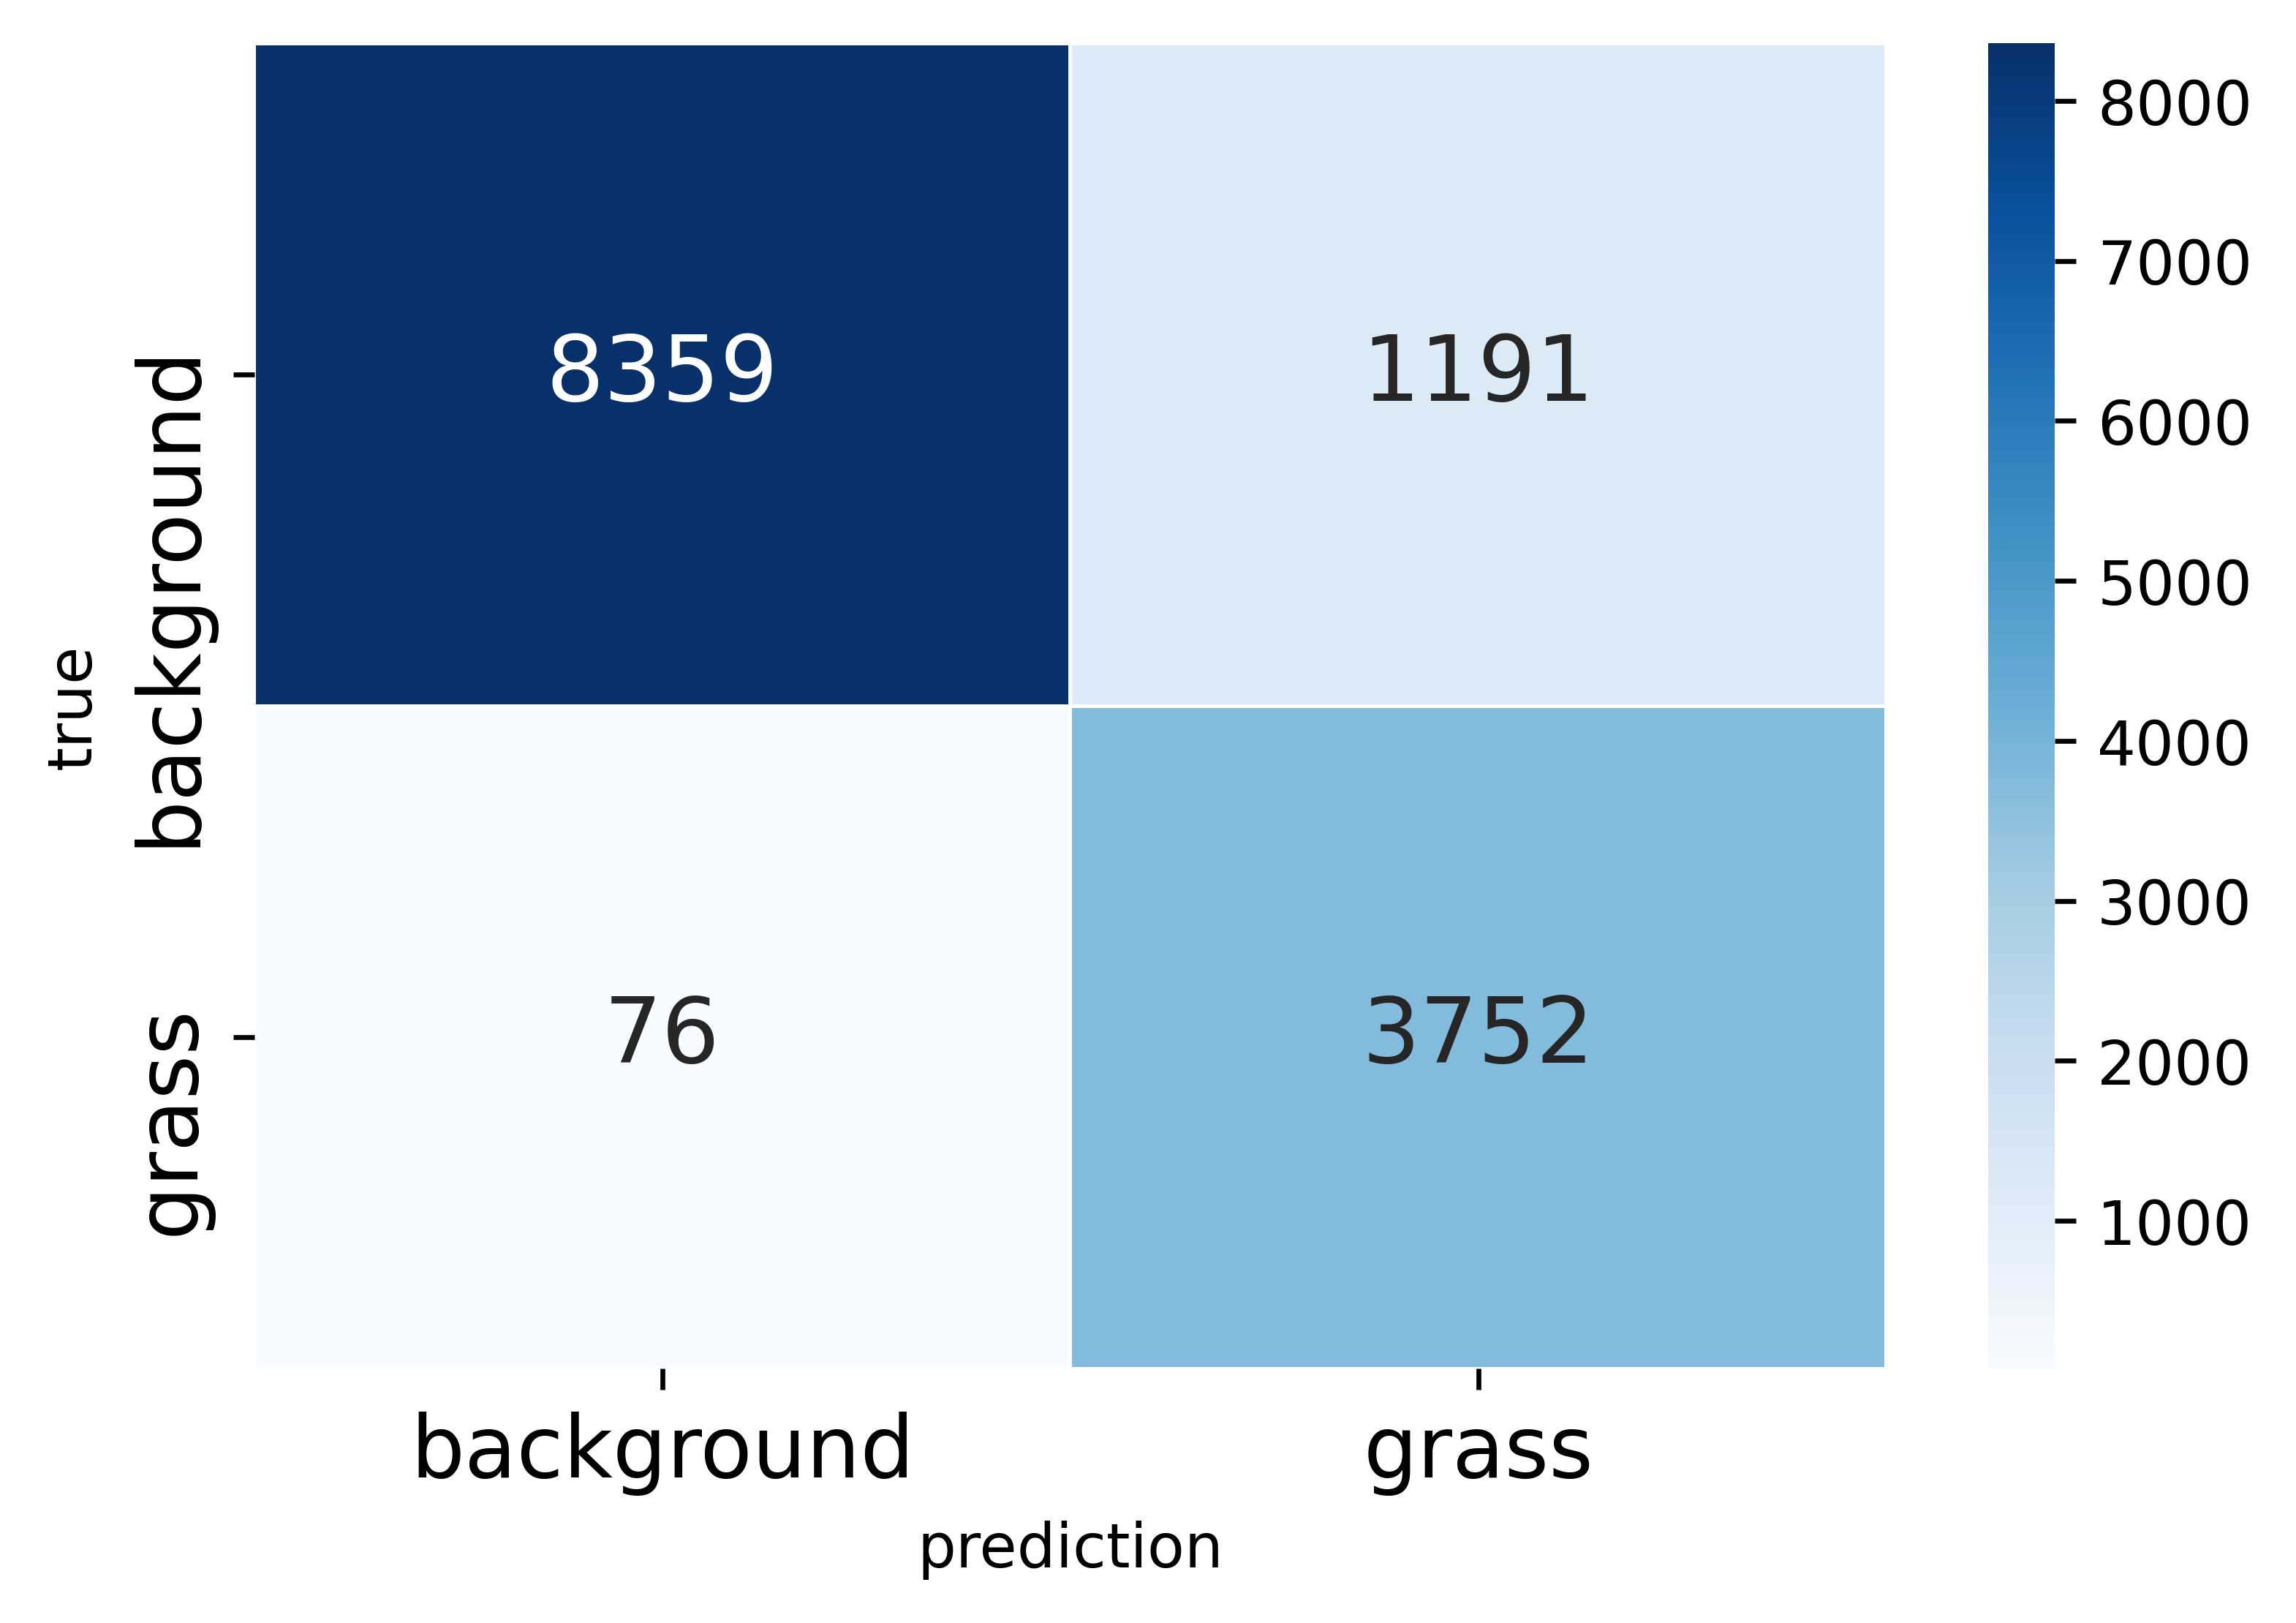

In [69]:
plt.figure(dpi = 600) 
sns.heatmap(cm, annot=True, annot_kws={"size": 15}, fmt='d', cmap = 'Blues', linewidth=.5)
plt.tick_params(labelsize = 14) # x font label size
plt.tick_params(labelsize = 14) # y font label size

In [2]:
#### os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="4"; 

In [3]:
train_paths_df = utilities.make_path_df(["grs_nogrs_Training.txt"])
valid_paths_df = utilities.make_path_df(["grs_nogrs_Validate.txt"])
test_paths_df = utilities.make_path_df(["grs_nogrs_Test.txt"])

In [4]:
# Check that it looks ok...
train_paths_df.head(5)

path  label
0  ../Dataset/data/Training/Ferny/Image375_Row1_C...  grass
1  ../Dataset/data/Training/Ferny/Image388_Row1_C...  grass
2  ../Dataset/data/Training/Ferny/Image505_Row3_C...  grass
3  ../Dataset/data/Training/Ferny/Image434_Row2_C...  grass
4  ../Dataset/data/Training/Ferny/Image586_Row4_C...  grass

In [5]:
#n = random.randint(0,len(all_paths_df))
#img = utilities.view_image(all_paths_df.iloc[n]["path"], all_paths_df.iloc[n]["label"], cmap="gray")
#print(all_paths_df.iloc[n]["path"])

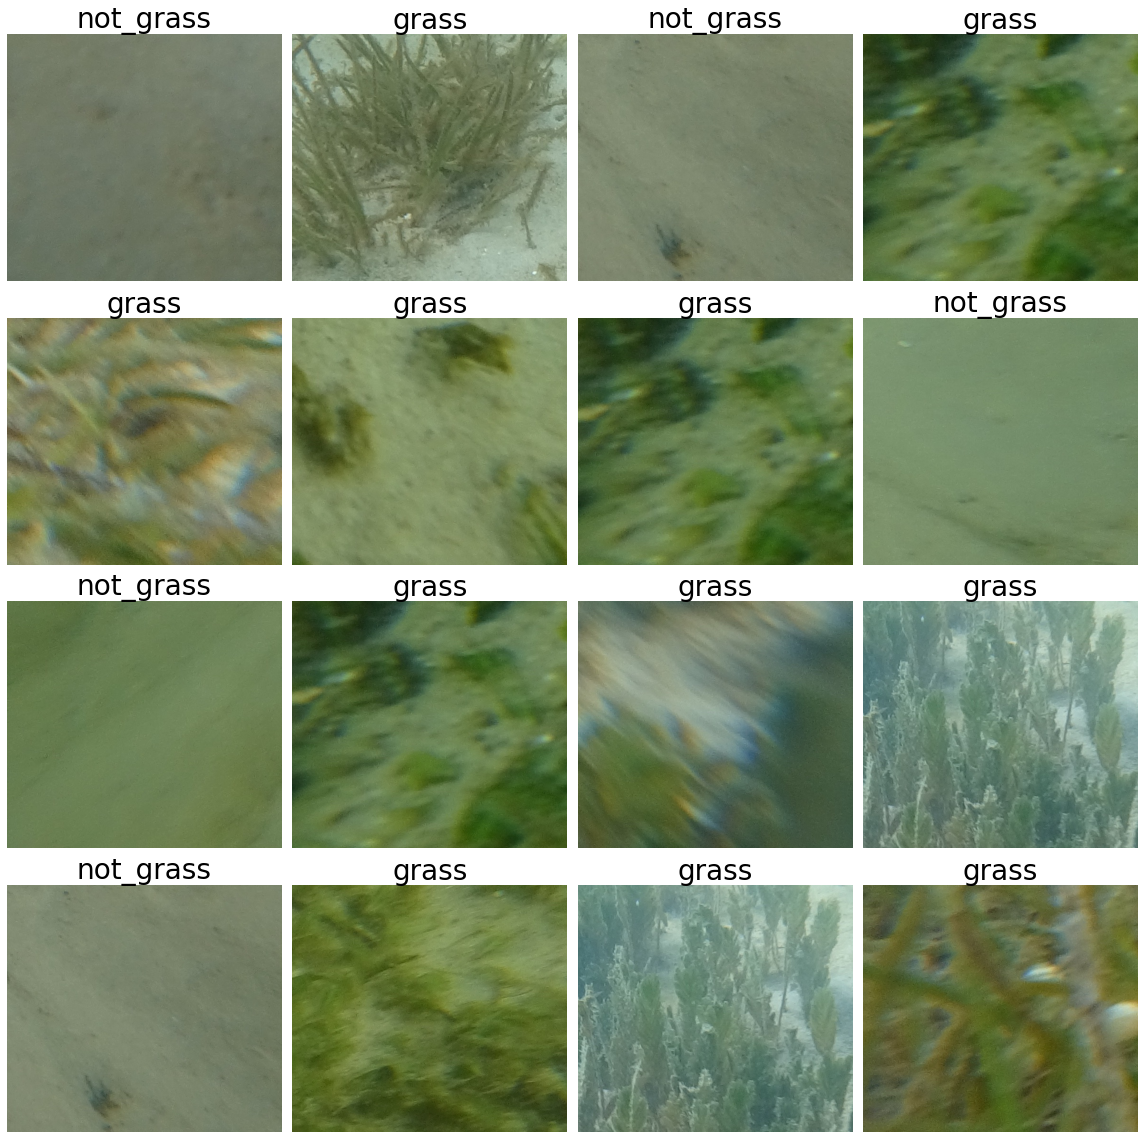

In [6]:
_ = utilities.view_images(train_paths_df, n_images=16, randomize=True).tight_layout()

In [7]:
# Create train/validation/test sets of the paths dataframe, proportions 0.70/0.15/0.15
# Test set is used in evaluation AFTER training only.
# train_paths_df, valid_paths_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)
# valid_paths_df, test_paths_df = train_test_split(test_paths_df, train_size=0.5, shuffle=True, random_state=4444)

# make datasets smaller for quicker training while developing:
#train_paths_df = train_paths_df[:int(len(train_paths_df)/4)]
#test_paths_df = test_paths_df[:int(len(test_paths_df)/4)]

In [8]:
work_img_size = 112,112 # 224, 224 is default for most pretrained models
input_shape = work_img_size + (3,) # 3 for rgb (model is pretrained on rgb imgs)
batch_size = 16 # try decreasing this in case of out-of-memory errors for the GPU

img_datagen = ImageDataGenerator()

# Generators to import data from directories and turn it into batches.
train_data = img_datagen.flow_from_dataframe(train_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='binary',
                                               validate_filenames=False,
                                               shuffle=True,
                                               seed=242)

valid_data = img_datagen.flow_from_dataframe(valid_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='binary',
                                               validate_filenames=False,
                                               shuffle=False,
                                               seed=242)

test_data  =  img_datagen.flow_from_dataframe(test_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='binary',
                                               validate_filenames=False,
                                               shuffle=False,
                                               seed=242)


Found 42848 non-validated image filenames belonging to 2 classes.
Found 10720 non-validated image filenames belonging to 2 classes.
Found 13378 non-validated image filenames belonging to 2 classes.


In [9]:
def do_transfer_learning(core_model, prepro_layer=None, weights="imagenet", cb=[],
                         input_shape=input_shape, freeze_layers=0, epochs=60):
    """

    :param core_model:
    :param prepro_layer:
    :param weights:
    :param cb:
    :param input_shape:
    :param freeze_layers:
    :param epochs:
    :return:
    """

    i = tf.keras.layers.Input(input_shape)
    core = core_model(weights=weights,
                      include_top=False,
                      input_tensor=i)
    x = core.output
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=i, outputs=x)
    
    # Freeze some layers
    print("Freezing the first " + str(freeze_layers) + " layers (out of " + str(len(model.layers)) + ").")
    for nr, layer in enumerate(model.layers):
        if nr < freeze_layers:
            layer.trainable = False
        else:
            layer.trainable = True
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), # def lr is 0.01
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy']
               )

    hist = model.fit(train_data,
                     verbose=2,
                     epochs=epochs, 
                     validation_data=valid_data,
                     callbacks=cb
                    )
                           
    return model, hist


In [10]:
def eval_model(model, history, test_data=test_data):
    
    hist_df = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    # fig.suptitle("Accuracy and Loss")
    ax1.plot(hist_df[["accuracy","val_accuracy"]])
    ax1.set_title("Accuracy")
    ax1.set_xlabel("epochs")
    ax1.set_ylim(top=1.0)

    ax2.plot(hist_df[["loss","val_loss"]])
    ax2.set_title("Loss")
    ax2.set_xlabel("epochs")
    ax2.set_ylim(bottom=0.0)

    fig.tight_layout()
    plt.tight_layout()
    plt.savefig("supervised_histories.png", dpi=300)
    #plt.show()
    
    y_probs = model.predict(test_data)
    y_preds = np.round(np.squeeze(y_probs)) # remove useless dimension

    # get the true labels from the ImageDataGenerator
    y_true = test_data.classes

    classnames = list(test_data.class_indices.keys())
    cm = sklearn.metrics.confusion_matrix(y_true, y_preds)

    disp = sklearn.metrics.ConfusionMatrixDisplay(cm, 
                                           # y_true, 
                                                            # y_preds,
                                                            #normalize="all", # to get percentages
                                                            # cmap="Blues",
                                                            # colorbar=False,
                                                            display_labels=classnames)
    
    # print(cm)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.savefig('confusion_Matrix.png', dpi=300)
    plt.show()
    cr = utilities.make_classification_report(y_true, y_preds, classnames)
    print(cr)
    return y_probs, y_preds, disp

In [11]:
# Make a few different callbacks
# Saves weights from the epoch with the lowest validation loss.
model_cpcb = tf.keras.callbacks.ModelCheckpoint(
                    filepath="best_checkpoint.ckpt",
                    verbose=1,
                    monitor='val_loss',
                    mode='min',
                    save_weights_only=True,
                    save_best_only=True)

# Stops training when loss is NaN. Should not normally happen.
nan_stopper = tf.keras.callbacks.TerminateOnNaN()

# Not used
class AccuracyEarlyStopperCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > .99:
            print("\nReached >0.99 validation accuracy. Stopping training...\n")   
            self.model.stop_training = True
acc_stopper = AccuracyEarlyStopperCallback()

In [12]:
model_vgg16, hist_vgg16 = do_transfer_learning(tf.keras.applications.vgg16.VGG16,
                                               cb=[nan_stopper, model_cpcb],
                                               input_shape=input_shape,
                                               freeze_layers=12,
                                               epochs=50)

Freezing the first 12 layers (out of 22).
Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.02018, saving model to best_checkpoint.ckpt
2678/2678 - 439s - loss: 0.0343 - accuracy: 0.9897 - val_loss: 0.0202 - val_accuracy: 0.9947
Epoch 2/50

Epoch 00002: val_loss improved from 0.02018 to 0.01981, saving model to best_checkpoint.ckpt
2678/2678 - 432s - loss: 0.0140 - accuracy: 0.9959 - val_loss: 0.0198 - val_accuracy: 0.9957
Epoch 3/50

Epoch 00003: val_loss did not improve from 0.01981
2678/2678 - 429s - loss: 0.0102 - accuracy: 0.9970 - val_loss: 0.0237 - val_accuracy: 0.9949
Epoch 4/50

Epoch 00004: val_loss did not improve from 0.01981
2678/2678 - 520s - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.0204 - val_accuracy: 0.9941
Epoch 5/50

Epoch 00005: val_loss improved from 0.01981 to 0.01757, saving model to best_checkpoint.ckpt
2678/2678 - 445s - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.0176 - val_accuracy: 0.9954
Epoch 6/50

Epoch 00006: val_loss did not improve from 0

In [13]:
model_vgg16.load_weights("best_checkpoint2.ckpt")

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for best_checkpoint2.ckpt

In [ ]:
pd.DataFrame(hist_vgg16.history)

loss  accuracy  val_loss  val_accuracy
0   0.040431  0.988658  0.021268      0.993563
1   0.012946  0.996126  0.015349      0.995709
2   0.010092  0.996849  0.017183      0.995896
3   0.008156  0.997853  0.014410      0.996362
4   0.006319  0.998436  0.018328      0.995522
5   0.004874  0.998693  0.017407      0.995896
6   0.004253  0.998786  0.018881      0.995616
7   0.003798  0.998926  0.017470      0.996175
8   0.003011  0.999113  0.017867      0.995896
9   0.002223  0.999417  0.018490      0.995336
10  0.001847  0.999510  0.018523      0.995709
11  0.001784  0.999650  0.025122      0.995429
12  0.002639  0.999370  0.016458      0.995989
13  0.001245  0.999673  0.019865      0.996082
14  0.001522  0.999580  0.022491      0.995709
15  0.000710  0.999767  0.023239      0.996455
16  0.000904  0.999720  0.023693      0.996269
17  0.000912  0.999720  0.022044      0.996735
18  0.001568  0.999650  0.022705      0.995896
19  0.000501  0.999837  0.023257      0.995802
20  0.000415  0.999883  0.025508      0.995709
21  0.000184  0.999930  0.028345      0.995896
22  0.000260  0.999930  0.026515      0.995802
23  0.000952  0.999767  0.023458      0.996082
24  0.000424  0.999860  0.024826      0.995896
25  0.000187  0.999930  0.028280      0.996082
26  0.000245  0.999930  0.027659      0.996082
27  0.000263  0.999907  0.026430      0.995989
28  0.000135  0.999977  0.029396      0.995522
29  0.000108  1.000000  0.030171      0.995802
30  0.000089  1.000000  0.033544      0.995709
31  0.000064  1.000000  0.033126      0.995709
32  0.001304  0.999743  0.025240      0.996269
33  0.000260  0.999930  0.026226      0.995709
34  0.000092  1.000000  0.029078      0.995802
35  0.000047  1.000000  0.031376      0.995896
36  0.000353  0.999930  0.026477      0.996082
37  0.000074  1.000000  0.027453      0.995989
38  0.000076  1.000000  0.031545      0.995802
39  0.000047  1.000000  0.030390      0.996175
40  0.000015  1.000000  0.031594      0.996269
41  0.000049  1.000000  0.031494      0.996175
42  0.000039  1.000000  0.032786      0.996082
43  0.000059  0.999977  0.030847      0.996175
44  0.000040  1.000000  0.031602      0.995896
45  0.000079  0.999977  0.031896      0.995989
46  0.000040  1.000000  0.035134      0.995802
47  0.000026  1.000000  0.033094      0.995802
48  0.000020  1.000000  0.033732      0.995896
49  0.000010  1.000000  0.035328      0.995896

In [ ]:
# test_df = utilities.make_path_df(["testing.txt"])

# test_data  =  img_datagen.flow_from_dataframe(test_df,
#                                                x_col='path',
#                                                y_col='label',
#                                                batch_size=batch_size,
#                                                target_size=work_img_size,
#                                                class_mode='binary',
#                                                validate_filenames=False,
#                                                shuffle=False,
#                                                seed=242)

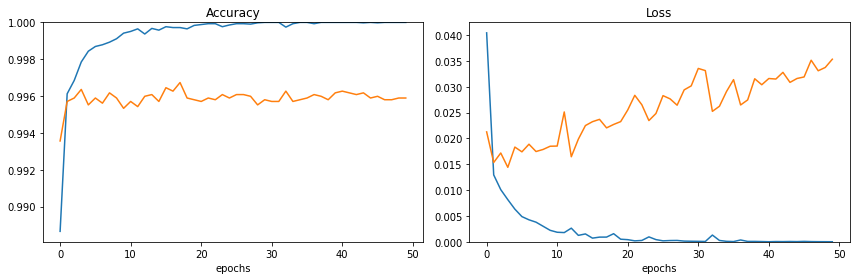

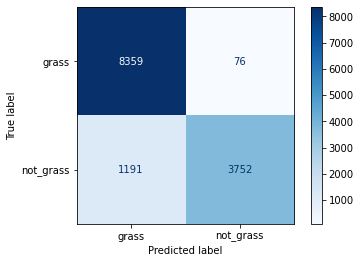

+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.9053
               Precision Recall  F1-score Support
 grass          0.8753   0.9910   0.9296   8435    
 not_grass      0.9801   0.7591   0.8555   4943    
 macro avg      0.9277   0.8750   0.8925   13378  
 weighted avg   0.9140   0.9053   0.9022   13378  


In [ ]:
probs, preds, disp = eval_model(model_vgg16, hist_vgg16, test_data)

In [ ]:
# Display misclassified images

# get the true labels from the ImageDataGenerator
y_true = test_data.classes

res = pd.DataFrame({"path": test_df["path"], "prob":probs[:,0], "pred": preds.astype(int), "true":y_true})
res["correct"] = res["pred"] == res["true"]
misclassified = res[res["correct"] == False]
misclassified.to_csv('supervised_misclassified.csv')

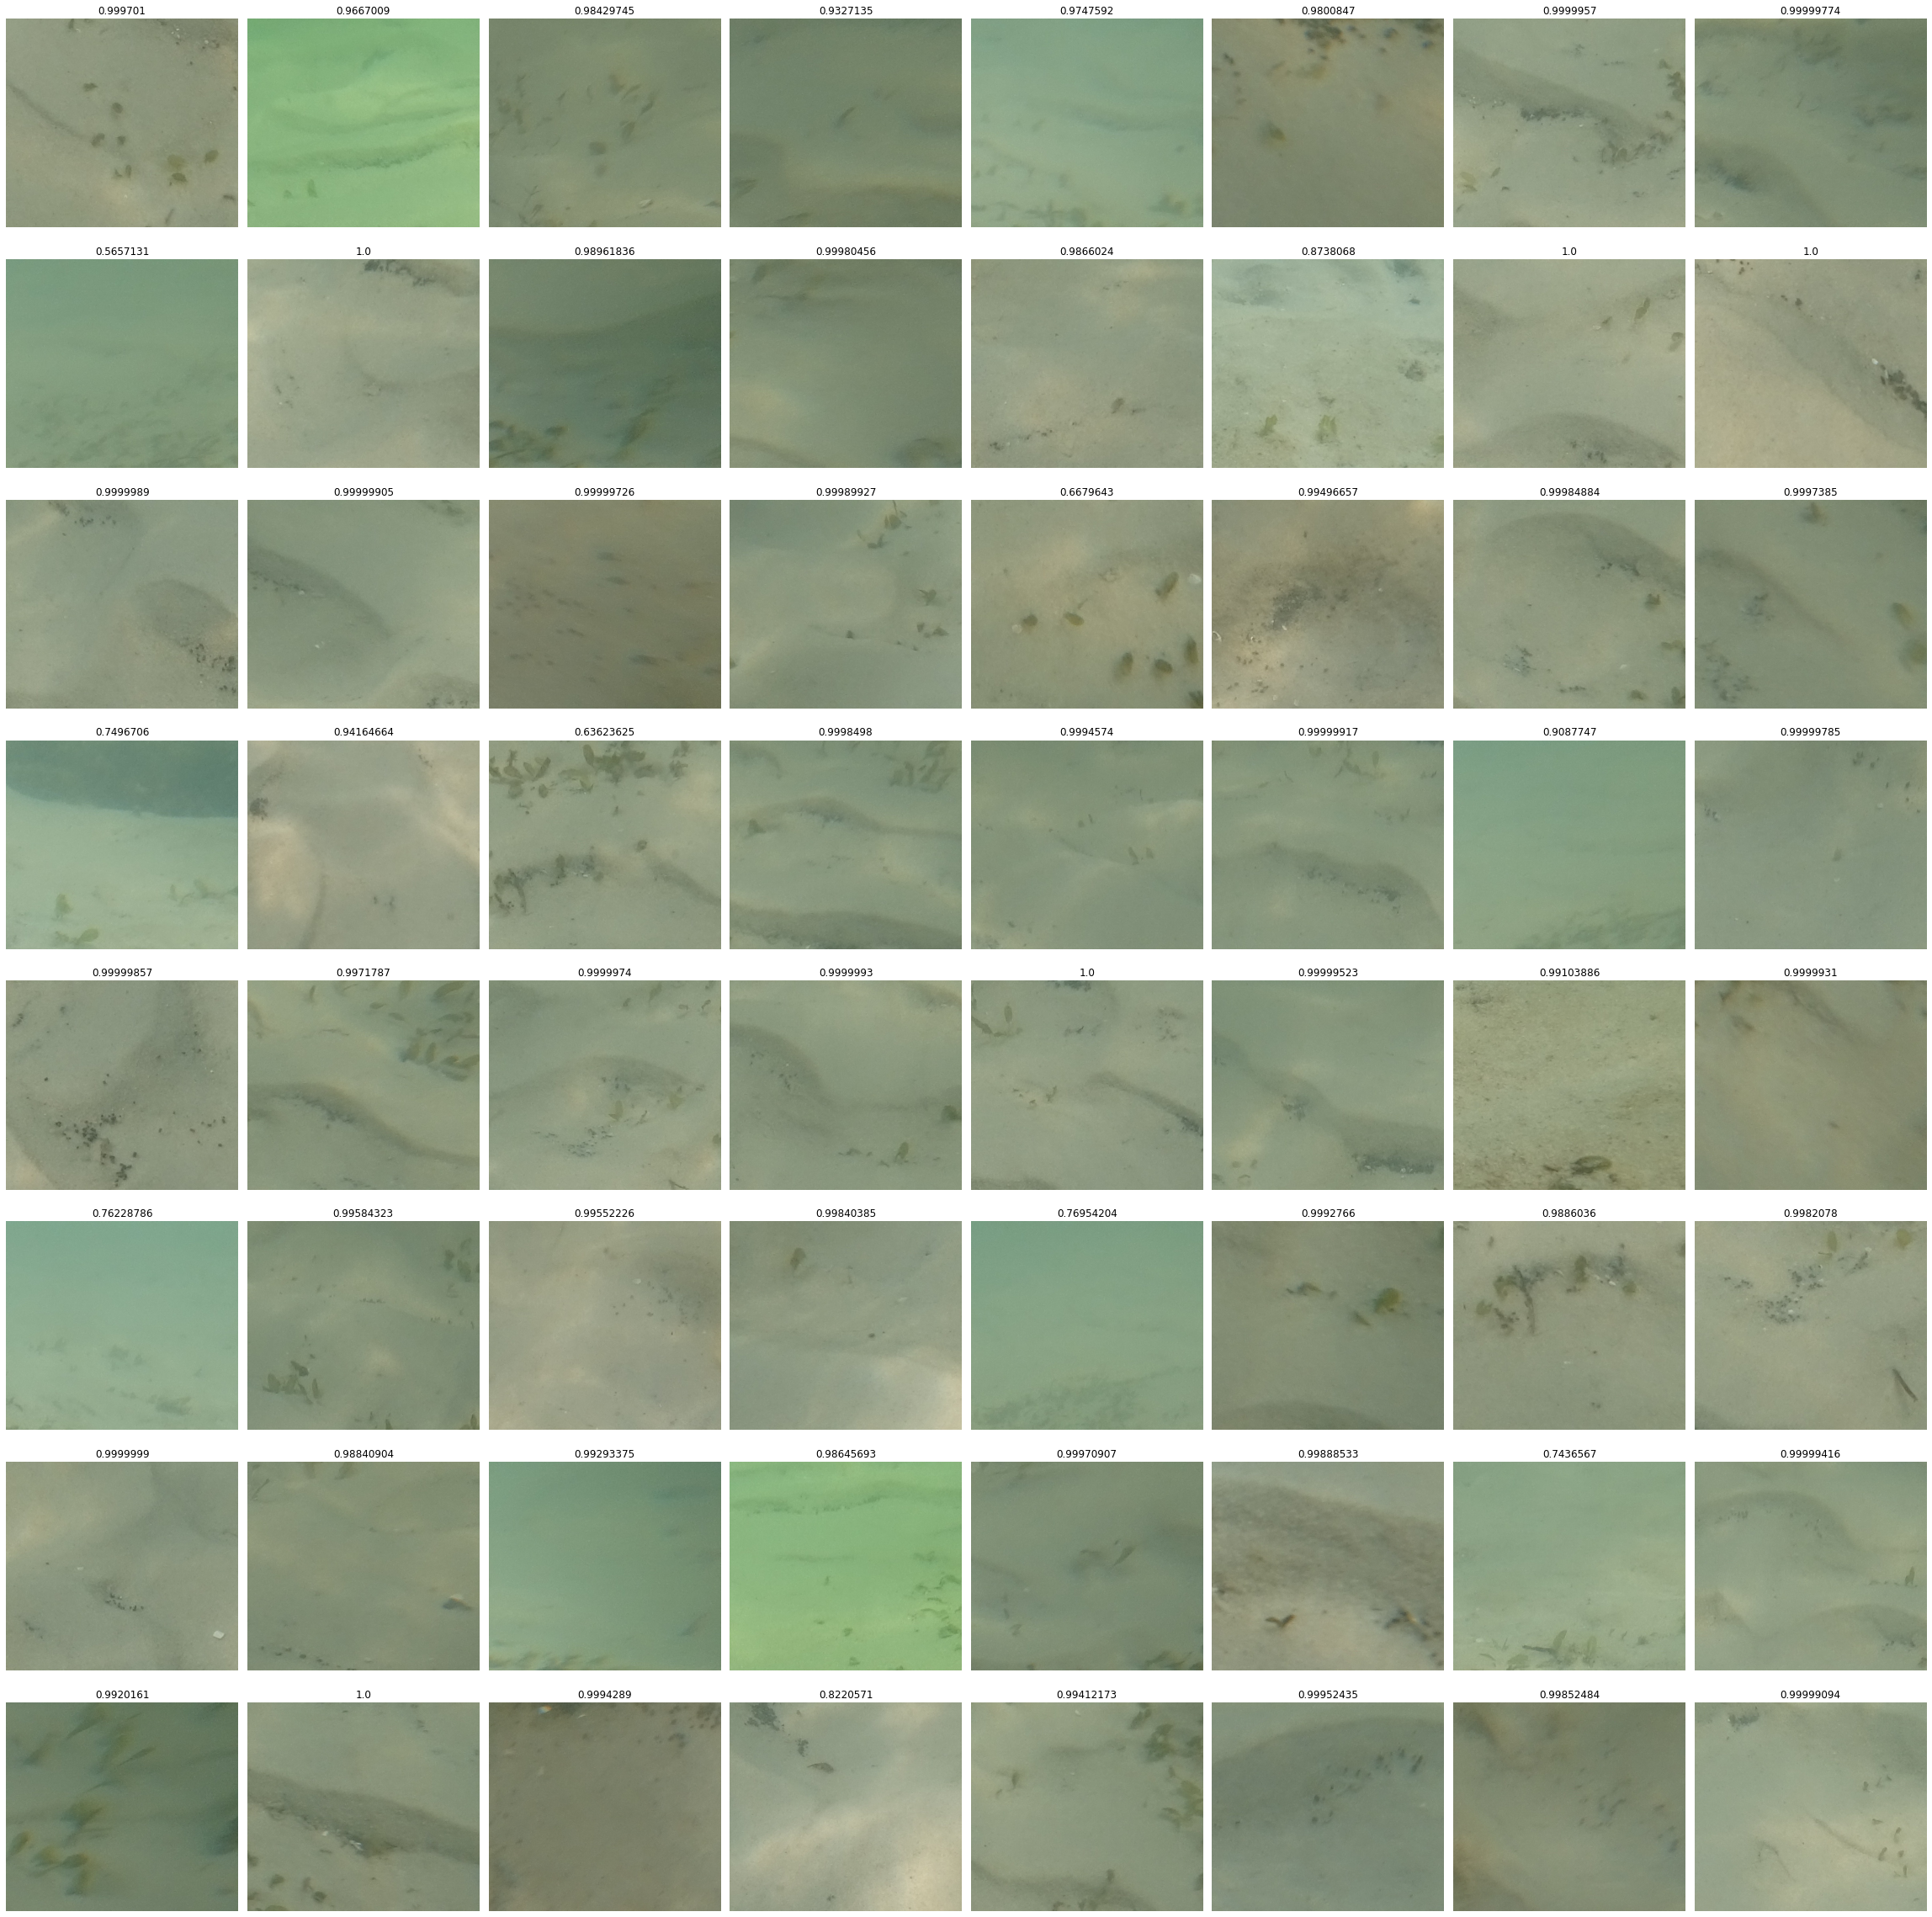

In [ ]:
_ = utilities.view_images(misclassified["path"], labels=misclassified["prob"], n_images=64).tight_layout()